In [1]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, Ridge
from xgboost import XGBClassifier, XGBRegressor

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

In [2]:
phase1DF = pd.read_csv(r'FinalData\phase1.csv')
phase2DF = pd.read_csv(r'FinalData\phase2.csv')
phase3DF = pd.read_csv(r'FinalData\phase3.csv')
preOpDataDF = pd.read_csv(r'FinalData\PreOp.csv')
outComesDF = pd.read_csv(r'FinalData\OutComes.csv')

phase1DF.columns = [phase1DF.columns[0]] + ['P1_' + col for col in phase1DF.columns[1:]]
phase2DF.columns = [phase2DF.columns[0]] + ['P2_' + col for col in phase2DF.columns[1:]]
phase3DF.columns = [phase3DF.columns[0]] + ['P3_' + col for col in phase3DF.columns[1:-9]] + list(phase3DF.columns[-9:])

allData = pd.merge(preOpDataDF, phase1DF , on = 'CPR' , how = 'left')
allData = pd.merge(allData, phase2DF , on = 'CPR' , how = 'left')
allData = pd.merge(allData, phase3DF , on = 'CPR' , how = 'left')

allData

,CPR,Age,Sex,Height,Weight,AlcoholPerWeek_0,AlcoholPerWeek_0.5-10,AlcoholPerWeek_11-20,AlcoholPerWeek_21-30,AlcoholPerWeek_31+,...,P3_TimeOfPhase,FC,FE,FG,FK,FM,FN,FP,FW,FX
0,0,78,0,172,80,0,0,1,0,0,...,68.0,0,0,0,0,0,1,0,0,0
1,1,70,0,175,95,0,0,0,1,0,...,102.0,0,0,0,0,1,1,1,0,1
2,2,66,1,160,73,0,0,0,0,0,...,54.0,0,0,0,0,1,0,0,0,1
3,3,65,0,164,61,0,0,0,0,0,...,73.0,0,0,0,0,0,1,0,0,1
4,4,67,1,162,59,0,0,0,0,0,...,175.0,0,0,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3884,3884,66,0,178,83,0,0,0,0,1,...,84.0,0,0,0,0,0,1,0,0,1
3885,3885,61,1,163,102,0,0,0,0,0,...,230.0,1,0,0,0,0,0,0,0,1
3886,3886,58,0,182,77,0,0,0,0,1,...,79.0,0,0,0,0,0,1,0,0,1
3887,3887,60,1,161,107,0,0,0,0,0,...,125.0,1,0,0,0,1,1,0,0,1


Defining loss functions

In [3]:
outComesDF['within90Days'].value_counts()

within90Days
0    3761
1     128
Name: count, dtype: int64

In [4]:
outComesDF['AKI'].value_counts()

AKI
0    2057
1    1832
Name: count, dtype: int64

In [5]:
outComesDF['ventilatorTime6h'].value_counts()

ventilatorTime6h
0    3067
1     822
Name: count, dtype: int64

In [6]:
data = allData.copy()

# Categorising the one-hot encoded data
categoricalData = pd.DataFrame(data['CPR'])
""" OperationOrder = ['FC', 'FE', 'FG', 'FK', 'FM', 'FN', 'FP', 'FW', 'FX']
categoricalData['Operations'] = data[OperationOrder].apply(lambda row: int("".join(map(str, row)), 2), axis=1) """
smokingOrder = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes']
categoricalData['Smoking'] = data[smokingOrder].idxmax(axis=1).apply(lambda x: smokingOrder.index(x)).to_numpy()
alcoholOrder = ['AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+']
categoricalData['Alcohol'] = data[alcoholOrder].idxmax(axis=1).apply(lambda x: alcoholOrder.index(x)).to_numpy()
""" diagnosesOrder = ['DiagnosisName_AcuteKidneyFailure', 'DiagnosisName_Arteriosclerosis', 'DiagnosisName_ChronicCAD', 
                  'DiagnosisName_ChronicKidneyFailure', 'DiagnosisName_EssentialHypertension', 'DiagnosisName_HyperChol', 
                  'DiagnosisName_Overweight', 'DiagnosisName_T1Diabetes', 'DiagnosisName_T2Diabetes']
categoricalData['Diagnoses'] = data[diagnosesOrder].apply(lambda row: int("".join(map(str, row)), 2), axis=1) """

normData = data.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'])
normData = pd.merge(normData, categoricalData , on = 'CPR' , how = 'left')
normData = normData.drop(columns = 'CPR')

X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(normData, outComesDF, test_size=0.2, stratify=outComesDF['within90Days'], random_state=0)


Standardized, one-hot data

In [7]:
standardData = allData.copy()

scaler = StandardScaler()
standardData[standardData.columns.difference(['CPR', 'Sex', 
                                              'FC', 'FE', 'FG', 'FK', 'FM', 'FN', 'FP', 'FW', 'FX',
                                              'SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes',
                                              'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+',
                                              'DiagnosisName_AcuteKidneyFailure', 'DiagnosisName_Arteriosclerosis', 'DiagnosisName_ChronicCAD', 
                                              'DiagnosisName_ChronicKidneyFailure', 'DiagnosisName_EssentialHypertension', 'DiagnosisName_HyperChol', 
                                              'DiagnosisName_Overweight', 'DiagnosisName_T1Diabetes', 'DiagnosisName_T2Diabetes', 
                                              'ckmb', 'troponin_i', 'troponin_t', 
                                              'P1_LAP', 'P1_PAP', 'P2_LAP', 'P2_PAP', 'P3_LAP', 'P3_PAP'
                                              ])] = scaler.fit_transform(standardData[standardData.columns.difference([
                                                  'CPR', 'Sex', 
                                                  'FC', 'FE', 'FG', 'FK', 'FM', 'FN', 'FP', 'FW', 'FX',
                                                  'SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes',
                                                  'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+',
                                                  'DiagnosisName_AcuteKidneyFailure', 'DiagnosisName_Arteriosclerosis', 'DiagnosisName_ChronicCAD', 
                                                  'DiagnosisName_ChronicKidneyFailure', 'DiagnosisName_EssentialHypertension', 'DiagnosisName_HyperChol', 
                                                  'DiagnosisName_Overweight', 'DiagnosisName_T1Diabetes', 'DiagnosisName_T2Diabetes', 
                                                  'ckmb', 'troponin_i', 'troponin_t', 
                                                  'P1_LAP', 'P1_PAP', 'P2_LAP', 'P2_PAP', 'P3_LAP', 'P3_PAP'])])

standardOutcomes = outComesDF.copy()
standardOutcomes[['TimeOfStayInDays' , 'TimeOfOperationInMinutes']] = scaler.fit_transform(standardOutcomes[['TimeOfStayInDays' , 'TimeOfOperationInMinutes']])

standardData = standardData.drop(columns = 'CPR')

X_train_std, X_test_std, y_train_std, y_test_std = train_test_split(standardData, standardOutcomes, test_size=0.2, stratify=standardOutcomes['within90Days'], random_state=0)

## Classification

### Logistic regression

Death


=== Phase 1: Using 47 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 6.1584821106602545, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.1379
Accuracy: 96.79%
Precision: 66.67%
Recall: 7.69%
ROC AUC: 78.75%

=== Phase 2: Using 98 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 6.1584821106602545, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.1935
Accuracy: 96.79%
Precision: 60.00%
Recall: 11.54%
ROC AUC: 75.97%

=== Phase 3: Using 133 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 1.8329807108324339, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.2353
Accuracy: 96.66%
Precision: 50.00%
Recall: 15.38%
ROC AUC: 80.02%

=== Phase 4: Using 193 features ===
Fitting 10 folds for 

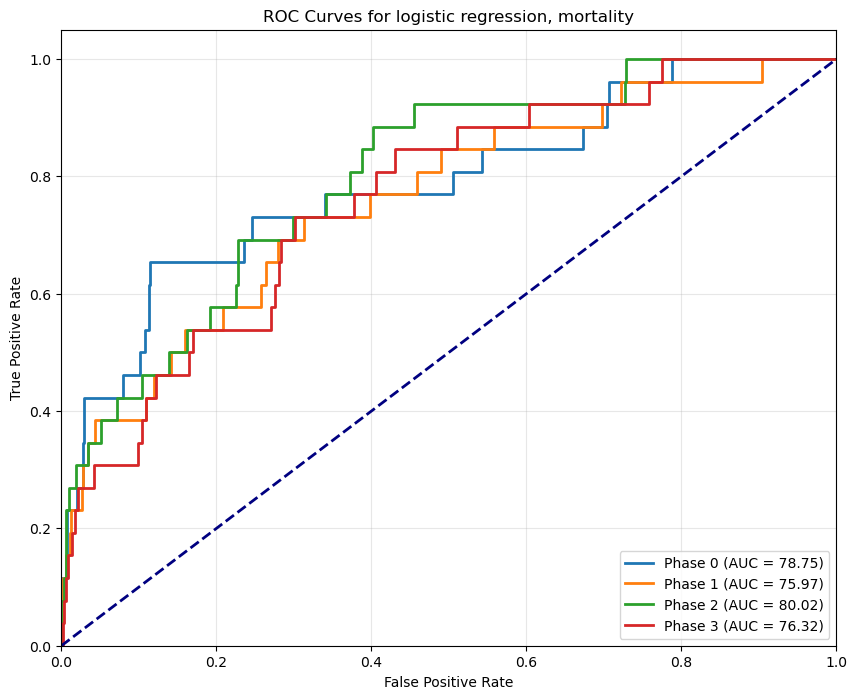

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        47  0.137931  96.786632  66.666667   7.692308  78.748977
1  Phase 1        98  0.193548  96.786632  60.000000  11.538462  75.971768
2  Phase 2       133  0.235294  96.658098  50.000000  15.384615  80.022504
3  Phase 3       193  0.222222  96.401028  40.000000  15.384615  76.324673


In [8]:
model = LogisticRegression()
C_parameter = np.logspace(-5, 5, 20)
#C_parameter = [1.1e-24]
param_grid = {
    'penalty' : ['l2'],
    'C' : C_parameter,
    'solver' : ['lbfgs'],
    'max_iter' : [10000],
    'class_weight'  : [None]
    }


#Define phases
preFeatures = preOpDataDF.columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i + 1}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['within90Days'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_std['within90Days'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_std['within90Days'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_std['within90Days'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_std['within90Days'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_std['within90Days'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_std['within90Days'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for logistic regression, mortality')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Respirator


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 20.6913808111479, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.1117
Accuracy: 77.51%
Precision: 45.83%
Recall: 6.36%
ROC AUC: 59.52%

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 784.7599703514607, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.1722
Accuracy: 77.76%
Precision: 50.00%
Recall: 10.40%
ROC AUC: 65.16%

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 0.5455594781168515, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.2632
Accuracy: 78.41%
Precision: 54.55%
Recall: 17.34%
ROC AUC: 67.59%

=== Phase 3: Using 193 features ===
Fitting 10 folds for eac

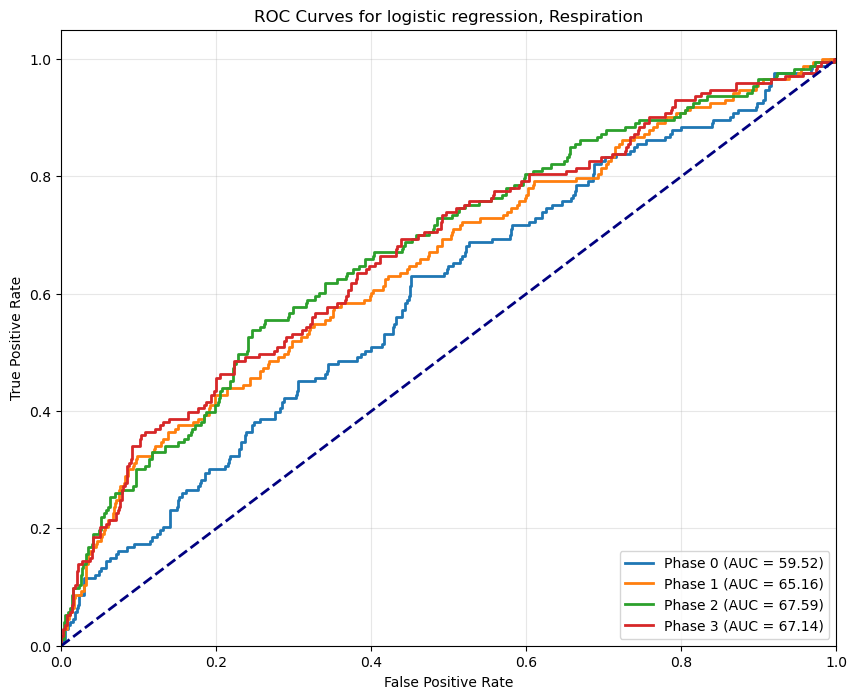

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        47  0.111675  77.506427  45.833333   6.358382  59.522285
1  Phase 1        98  0.172249  77.763496  50.000000  10.404624  65.164095
2  Phase 2       133  0.263158  78.406170  54.545455  17.341040  67.588974
3  Phase 3       193  0.292683  77.634961  49.315068  20.809249  67.140878


In [9]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['ventilatorTime6h'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_std['ventilatorTime6h'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_std['ventilatorTime6h'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_std['ventilatorTime6h'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_std['ventilatorTime6h'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_std['ventilatorTime6h'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_std['ventilatorTime6h'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for logistic regression, Respiration')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

AKI


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 29763.51441631313, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.5302
Accuracy: 59.00%
Precision: 56.78%
Recall: 49.72%
ROC AUC: 61.75%

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 6.1584821106602545, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.5893
Accuracy: 63.62%
Precision: 62.08%
Recall: 56.08%
ROC AUC: 67.78%

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'C': 2636.6508987303555, 'class_weight': None, 'max_iter': 10000, 'penalty': 'l2', 'solver': 'lbfgs'}
Final Model F1 Score: 0.6271
Accuracy: 66.07%
Precision: 64.16%
Recall: 61.33%
ROC AUC: 71.94%

=== Phase 3: Using 193 features ===
Fitting 10 folds for 

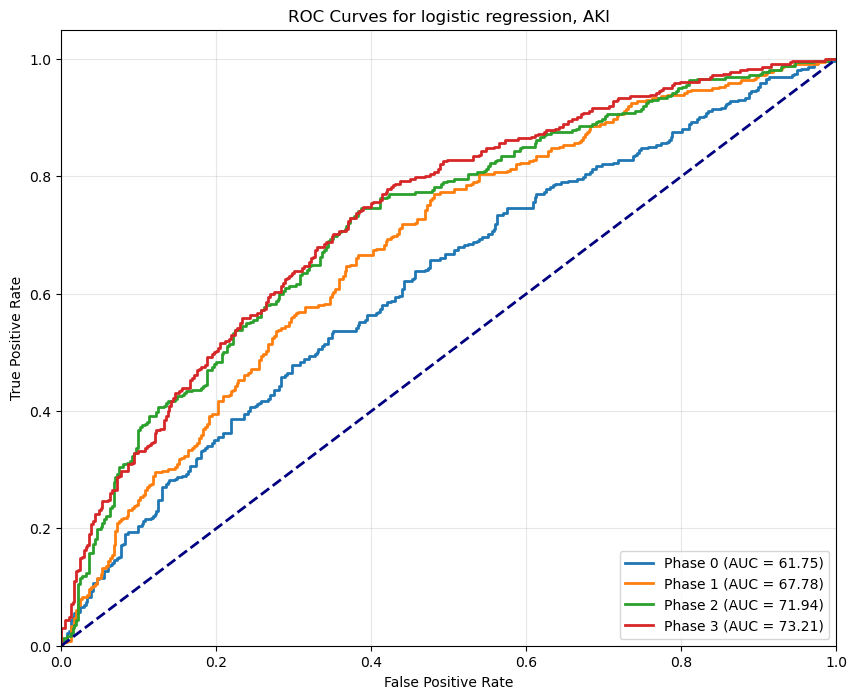

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        47  0.530191  58.997429  56.782334  49.723757  61.745644
1  Phase 1        98  0.589260  63.624679  62.079511  56.077348  67.783149
2  Phase 2       133  0.627119  66.066838  64.161850  61.325967  71.943397
3  Phase 3       193  0.625000  66.838046  65.950920  59.392265  73.212388


In [10]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['AKI'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_std['AKI'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_std['AKI'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_std['AKI'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_std['AKI'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_std['AKI'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_std['AKI'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for logistic regression, AKI')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### Classification tree

Death


=== Phase 1: Using 38 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 15, 'max_features': None}
Final Model F1 Score: 0.1053
Accuracy: 93.44%
Precision: 9.68%
Recall: 11.54%
ROC AUC: 53.95%

=== Phase 2: Using 89 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None}
Final Model F1 Score: 0.1509
Accuracy: 94.22%
Precision: 14.81%
Recall: 15.38%
ROC AUC: 56.53%

=== Phase 3: Using 124 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Final Model F1 Score: 0.1497
Accuracy: 79.56%
Precision: 8.70%
Recall: 53.85%
ROC AUC: 64.42%

=== Phase 4: Using 184 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits

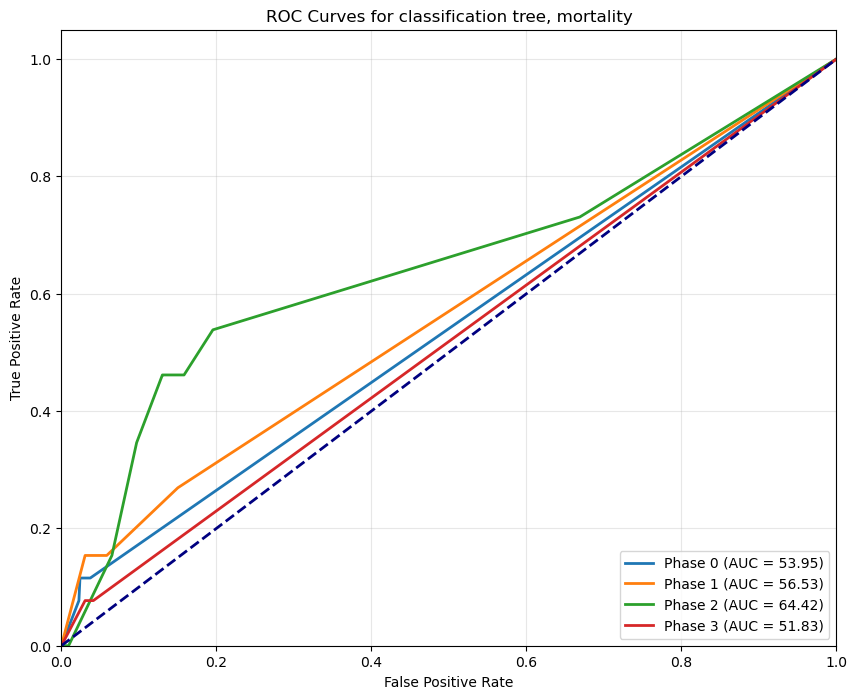

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        38  0.105263  93.444730   9.677419  11.538462  53.945888
1  Phase 1        89  0.150943  94.215938  14.814815  15.384615  56.531301
2  Phase 2       124  0.149733  79.562982   8.695652  53.846154  64.417962
3  Phase 3       184  0.078431  93.958869   8.000000   7.692308  51.825900


In [11]:
model = DecisionTreeClassifier(random_state=0)

param_grid = {
    'criterion': ['entropy'],
    'max_depth': [None, 5, 10, 15, 20],              
    'max_features': [None],  #None
    'class_weight': [None , 'balanced'],   #None
}

#Define phases
preFeatures = preOpDataDF.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'
                            ]).columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i + 1}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['within90Days'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_norm['within90Days'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_norm['within90Days'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_norm['within90Days'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_norm['within90Days'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_norm['within90Days'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_norm['within90Days'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for classification tree, mortality')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Respirator


=== Phase 1: Using 38 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Final Model F1 Score: 0.3575
Accuracy: 65.81%
Precision: 30.71%
Recall: 42.77%
ROC AUC: 59.17%

=== Phase 2: Using 89 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Final Model F1 Score: 0.3907
Accuracy: 59.51%
Precision: 29.36%
Recall: 58.38%
ROC AUC: 61.89%

=== Phase 3: Using 124 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Final Model F1 Score: 0.3888
Accuracy: 66.45%
Precision: 32.68%
Recall: 47.98%
ROC AUC: 59.26%

=== Phase 4: Using 184 features ===
Fitting 10 folds for each of 10 candidates, totalling 10

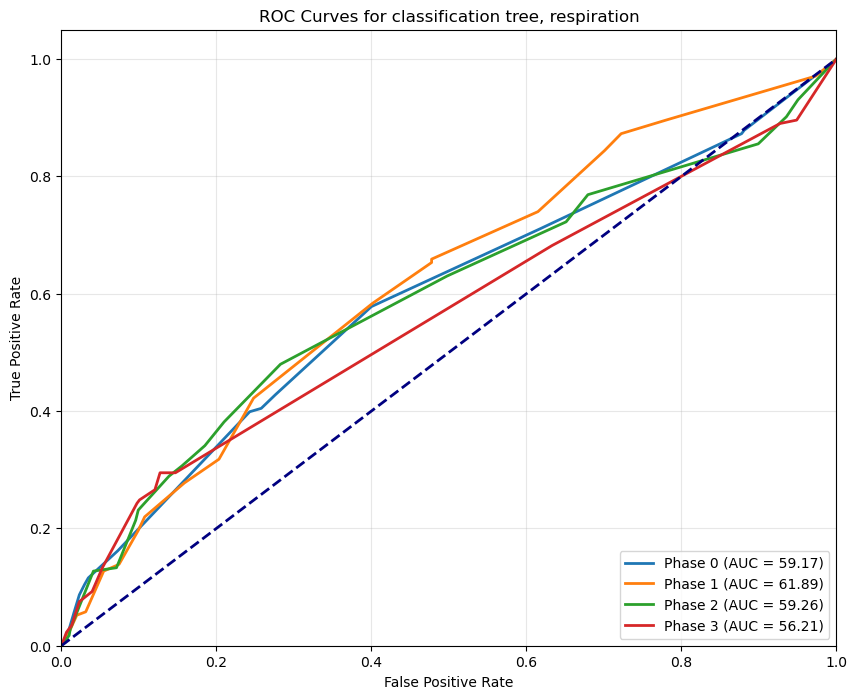

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        38  0.357488  65.809769  30.705394  42.774566  59.169254
1  Phase 1        89  0.390716  59.511568  29.360465  58.381503  61.886017
2  Phase 2       124  0.388759  66.452442  32.677165  47.976879  59.262886
3  Phase 3       184  0.338870  74.421594  39.843750  29.479769  56.209812


In [12]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i + 1}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['ventilatorTime6h'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_norm['ventilatorTime6h'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_norm['ventilatorTime6h'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_norm['ventilatorTime6h'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_norm['ventilatorTime6h'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_norm['ventilatorTime6h'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_norm['ventilatorTime6h'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for classification tree, respiration')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

AKI


=== Phase 1: Using 38 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': None}
Final Model F1 Score: 0.5520
Accuracy: 56.81%
Precision: 53.35%
Recall: 57.18%
ROC AUC: 56.84%

=== Phase 2: Using 89 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 10, 'max_features': None}
Final Model F1 Score: 0.4615
Accuracy: 58.61%
Precision: 58.47%
Recall: 38.12%
ROC AUC: 58.31%

=== Phase 3: Using 124 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 5, 'max_features': None}
Final Model F1 Score: 0.5828
Accuracy: 65.04%
Precision: 65.52%
Recall: 52.49%
ROC AUC: 65.41%

=== Phase 4: Using 184 features ===
Fitting 10 folds for each of 10 candidates, totalling 100 

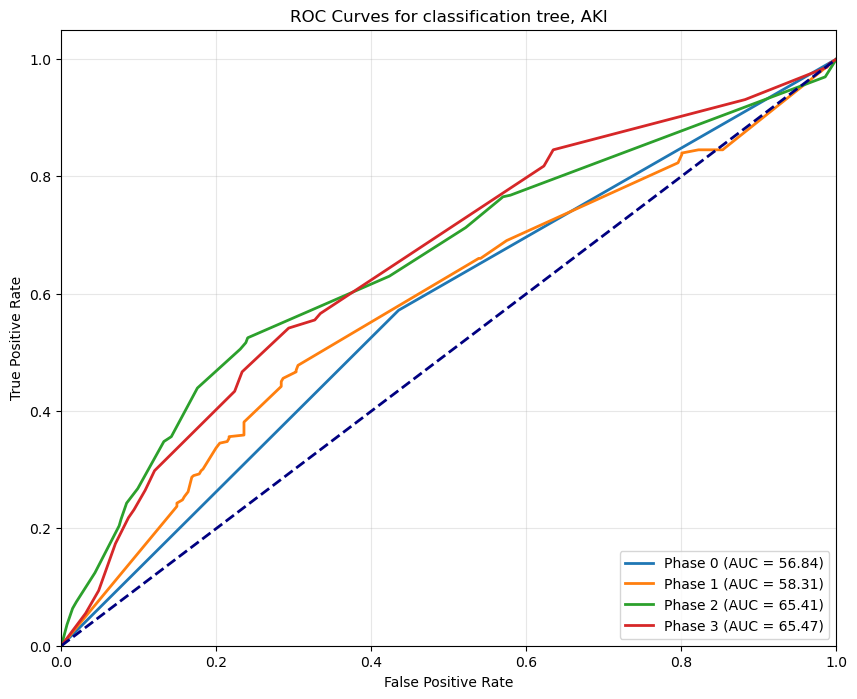

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        38  0.552000  56.812339  53.350515  57.182320  56.836353
1  Phase 1        89  0.461538  58.611825  58.474576  38.121547  58.305886
2  Phase 2       124  0.582822  65.038560  65.517241  52.486188  65.406197
3  Phase 3       184  0.580737  61.953728  59.593023  56.629834  65.471273


In [13]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i + 1}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['AKI'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_norm['AKI'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_norm['AKI'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_norm['AKI'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_norm['AKI'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_norm['AKI'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_norm['AKI'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for classification tree, AKI')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### Multi-Layer Perceptron

Death


=== Phase 1: Using 47 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.00011288378916846884, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Final Model F1 Score: 0.2326
Accuracy: 95.76%
Precision: 29.41%
Recall: 19.23%
ROC AUC: 70.91%

=== Phase 2: Using 98 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 0.04832930238571752, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Final Model F1 Score: 0.0513
Accuracy: 95.24%
Precision: 7.69%
Recall: 3.85%
ROC AUC: 65.35%

=== Phase 3: Using 133 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 0.04832930238571752, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Final Model F1 Score: 0.2381
Accuracy: 95.89%
Precision: 31.25%
Recall:

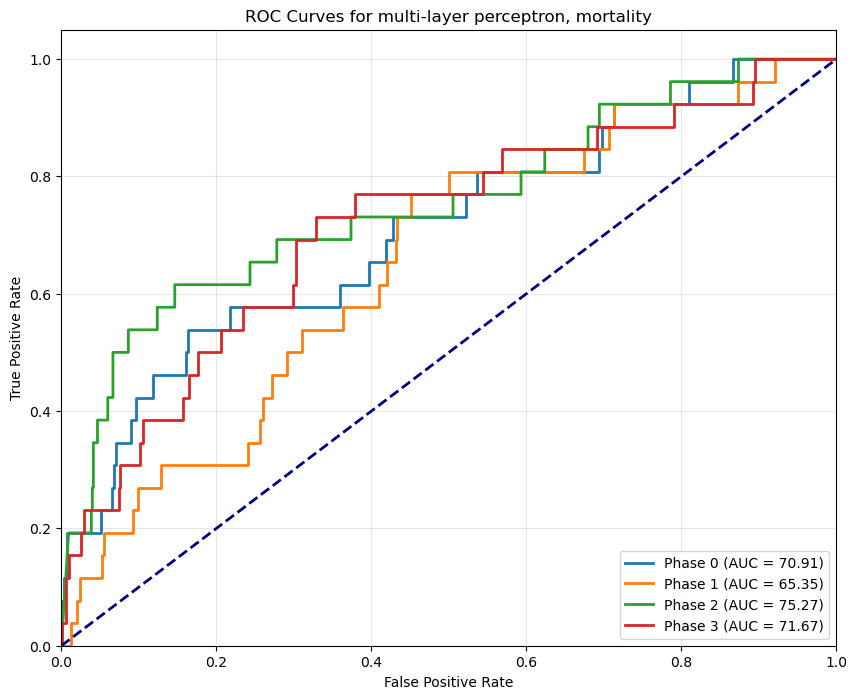

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        47  0.232558  95.758355  29.411765  19.230769  70.913462
1  Phase 1        98  0.051282  95.244216   7.692308   3.846154  65.353928
2  Phase 2       133  0.238095  95.886889  31.250000  19.230769  75.268515
3  Phase 3       193  0.166667  94.858612  18.181818  15.384615  71.670417


In [14]:
model = MLPClassifier(max_iter=1000, random_state=0) #Increase max_iter

param_grid = {
    'hidden_layer_sizes': [(2,), (5,), (10,)], #potentially not 15 20
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': C_parameter, #Do the same as regression C_parameter
    'learning_rate_init': [0.001, 0.01, 0.1] 
}


#Define phases
preFeatures = preOpDataDF.columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i + 1}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['within90Days'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_std['within90Days'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_std['within90Days'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_std['within90Days'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_std['within90Days'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_std['within90Days'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_std['within90Days'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for multi-layer perceptron, mortality')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Respirator


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.04832930238571752, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Final Model F1 Score: 0.1962
Accuracy: 72.62%
Precision: 28.26%
Recall: 15.03%
ROC AUC: 58.01%

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.1623776739188721, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Final Model F1 Score: 0.2207
Accuracy: 70.95%
Precision: 27.35%
Recall: 18.50%
ROC AUC: 55.89%

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.01438449888287663, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.01, 'solver': 'adam'}
Final Model F1 Score: 0.3484
Accuracy: 74.04%
Precision: 39.42%
Recall: 

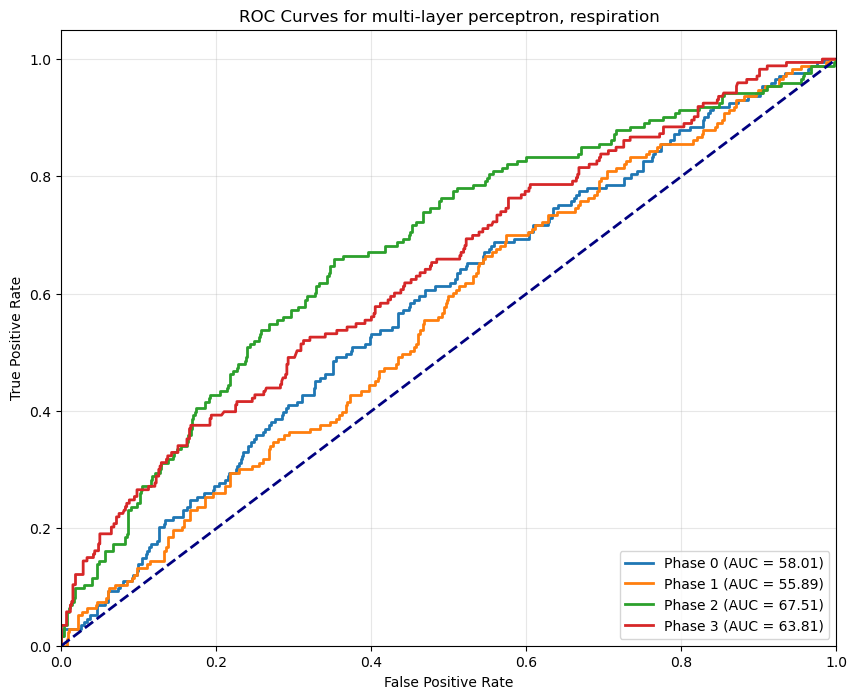

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        47  0.196226  72.622108  28.260870  15.028902  58.006975
1  Phase 1        98  0.220690  70.951157  27.350427  18.497110  55.886877
2  Phase 2       133  0.348387  74.035990  39.416058  31.213873  67.505852
3  Phase 3       193  0.325088  75.449871  41.818182  26.589595  63.806430


In [15]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['ventilatorTime6h'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_std['ventilatorTime6h'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_std['ventilatorTime6h'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_std['ventilatorTime6h'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_std['ventilatorTime6h'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_std['ventilatorTime6h'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_std['ventilatorTime6h'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for multi-layer perceptron, respiration')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

AKI


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 0.01438449888287663, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Final Model F1 Score: 0.6101
Accuracy: 62.21%
Precision: 58.67%
Recall: 63.54%
ROC AUC: 66.19%

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 0.04832930238571752, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Final Model F1 Score: 0.6411
Accuracy: 63.88%
Precision: 59.62%
Recall: 69.34%
ROC AUC: 68.55%

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 0.00011288378916846884, 'hidden_layer_sizes': (2,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Final Model F1 Score: 0.6020
Accuracy: 64.65%
Precision: 63.22%
Recall: 57

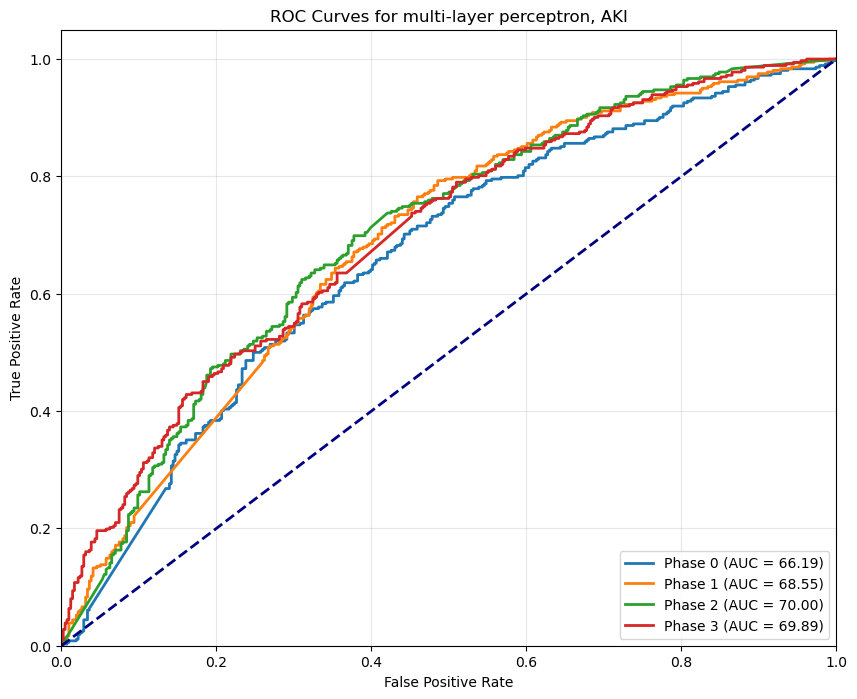

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        47  0.610080  62.210797  58.673469  63.535912  66.185455
1  Phase 1        98  0.641124  63.881748  59.619952  69.337017  68.547798
2  Phase 2       133  0.602026  64.652956  63.221884  57.458564  69.999402
3  Phase 3       193  0.568452  62.724936  61.612903  52.762431  69.885186


In [16]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['AKI'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_std['AKI'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_std['AKI'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_std['AKI'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_std['AKI'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_std['AKI'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_std['AKI'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for multi-layer perceptron, AKI')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### XGBoost

Death


=== Phase 1: Using 38 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:20:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.004281332398719391}
Final Model F1 Score: 0.0714
Accuracy: 96.66%
Precision: 50.00%
Recall: 3.85%
ROC AUC: 72.78%

=== Phase 2: Using 89 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:29:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 0, 'reg_lambda': 0.01438449888287663}
Final Model F1 Score: 0.0714
Accuracy: 96.66%
Precision: 50.00%
Recall: 3.85%
ROC AUC: 71.03%

=== Phase 3: Using 124 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [16:45:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Program Files\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1e-05}
Final Model F1 Score: 0.0000
Accuracy: 96.66%
Precision: 0.00%
Recall: 0.00%
ROC AUC: 72.45%

=== Phase 4: Using 184 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:09:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.04832930238571752}
Final Model F1 Score: 0.0714
Accuracy: 96.66%
Precision: 50.00%
Recall: 3.85%
ROC AUC: 80.09%


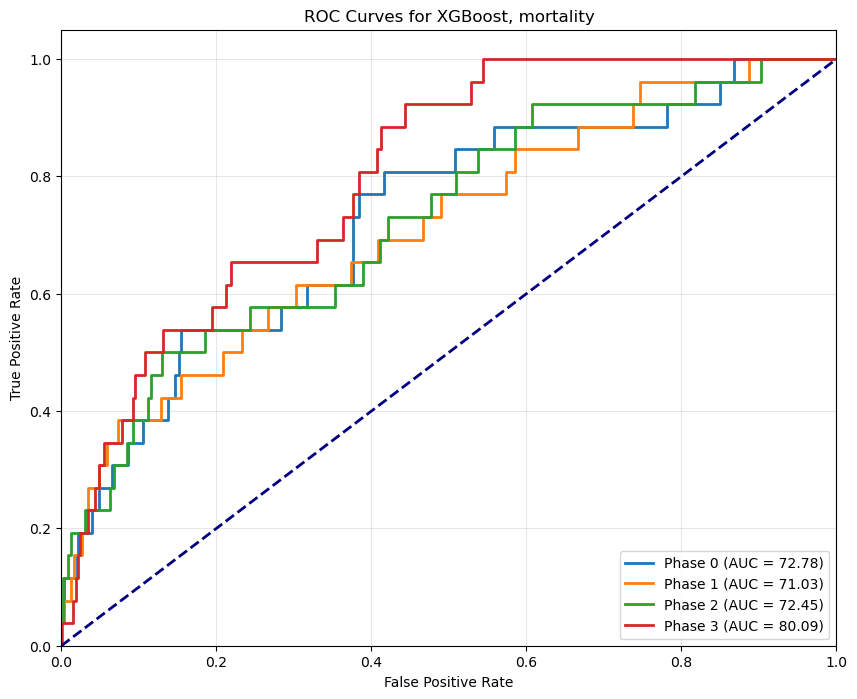

     Phase  Features  F1 Score   Accuracy  Precision    Recall    ROC AUC
0  Phase 0        38  0.071429  96.658098       50.0  3.846154  72.775164
1  Phase 1        89  0.071429  96.658098       50.0  3.846154  71.031097
2  Phase 2       124  0.000000  96.658098        0.0  0.000000  72.452946
3  Phase 3       184  0.071429  96.658098       50.0  3.846154  80.088993


In [17]:
model = XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [50, 100, 200],
    #'scale_pos_weight': [0.75 * scale_pos_weight, scale_pos_weight, 1.25 * scale_pos_weight],
    'reg_alpha': [0],
    'reg_lambda': C_parameter
}


#Define phases
preFeatures = preOpDataDF.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'
                            ]).columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['within90Days'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_norm['within90Days'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_norm['within90Days'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_norm['within90Days'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_norm['within90Days'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_norm['within90Days'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_norm['within90Days'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost, mortality')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Respirator


=== Phase 0: Using 38 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:11:45] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 1.8329807108324339}
Final Model F1 Score: 0.2192
Accuracy: 78.02%
Precision: 52.17%
Recall: 13.87%
ROC AUC: 60.32%

=== Phase 1: Using 89 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:26:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.0012742749857031334}
Final Model F1 Score: 0.2326
Accuracy: 78.79%
Precision: 59.52%
Recall: 14.45%
ROC AUC: 64.89%

=== Phase 2: Using 124 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [17:50:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.0012742749857031334}
Final Model F1 Score: 0.2735
Accuracy: 78.15%
Precision: 52.46%
Recall: 18.50%
ROC AUC: 66.14%

=== Phase 3: Using 184 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:22:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.000379269019073225}
Final Model F1 Score: 0.3231
Accuracy: 80.08%
Precision: 66.07%
Recall: 21.39%
ROC AUC: 67.65%


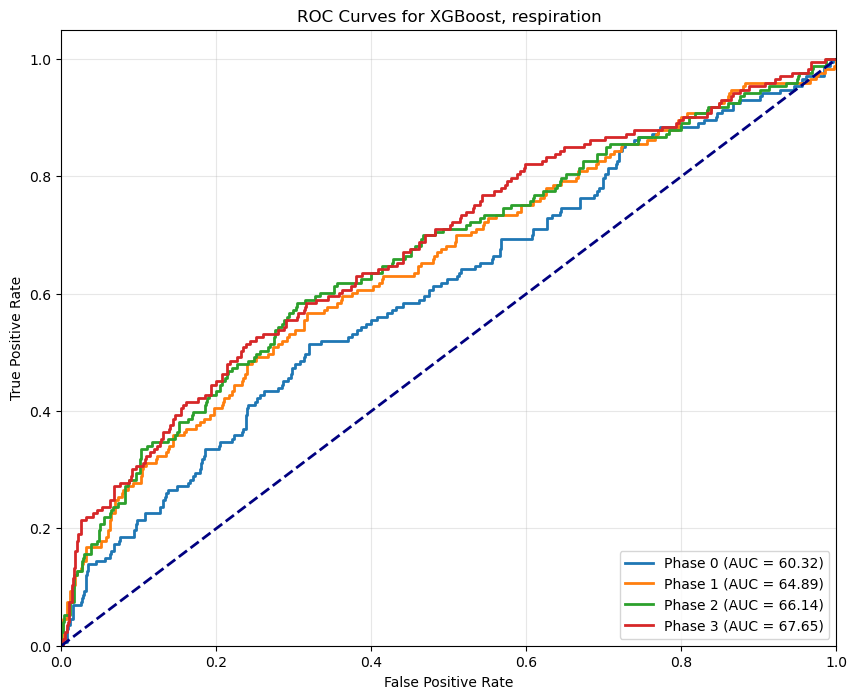

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        38  0.219178  78.020566  52.173913  13.872832  60.318158
1  Phase 1        89  0.232558  78.791774  59.523810  14.450867  64.885110
2  Phase 2       124  0.273504  78.149100  52.459016  18.497110  66.142454
3  Phase 3       184  0.323144  80.077121  66.071429  21.387283  67.647256


In [18]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['ventilatorTime6h'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_norm['ventilatorTime6h'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_norm['ventilatorTime6h'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_norm['ventilatorTime6h'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_norm['ventilatorTime6h'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_norm['ventilatorTime6h'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_norm['ventilatorTime6h'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost, respiration')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

AKI


=== Phase 0: Using 38 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:24:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 0.01438449888287663}
Final Model F1 Score: 0.5594
Accuracy: 60.93%
Precision: 58.84%
Recall: 53.31%
ROC AUC: 65.07%

=== Phase 1: Using 89 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [18:38:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 20.6913808111479}
Final Model F1 Score: 0.6278
Accuracy: 65.55%
Precision: 63.13%
Recall: 62.43%
ROC AUC: 72.33%

=== Phase 2: Using 124 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:01:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 3.359818286283781e-05}
Final Model F1 Score: 0.6408
Accuracy: 66.71%
Precision: 64.35%
Recall: 63.81%
ROC AUC: 72.68%

=== Phase 3: Using 184 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits


C:\Users\clun0178\AppData\Roaming\Python\Python311\site-packages\xgboost\core.py:158: UserWarning: [19:37:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 0, 'reg_lambda': 233.57214690901213}
Final Model F1 Score: 0.6544
Accuracy: 68.51%
Precision: 66.86%
Recall: 64.09%
ROC AUC: 76.48%


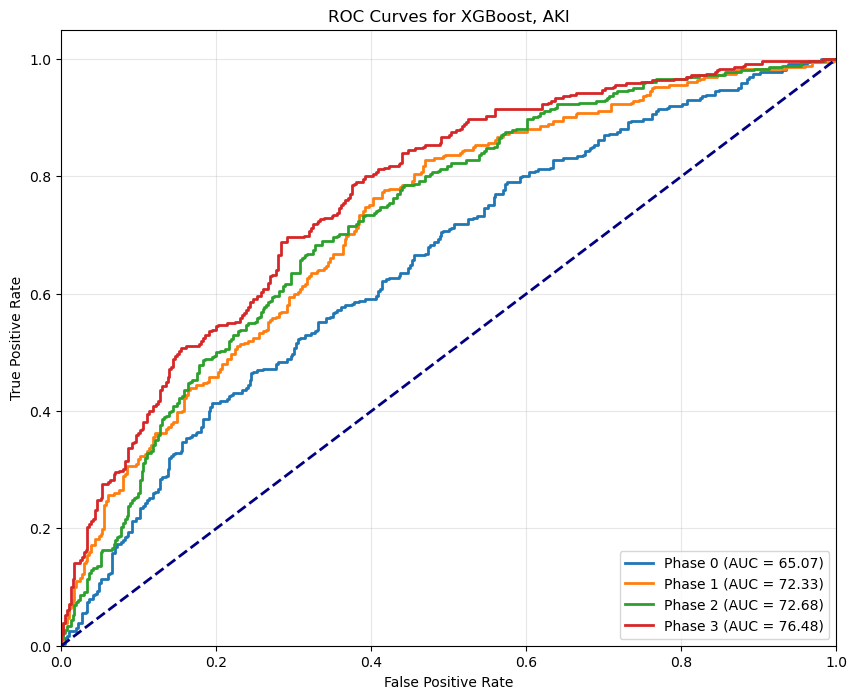

     Phase  Features  F1 Score   Accuracy  Precision     Recall    ROC AUC
0  Phase 0        38  0.559420  60.925450  58.841463  53.314917  65.071186
1  Phase 1        89  0.627778  65.552699  63.128492  62.430939  72.330535
2  Phase 2       124  0.640777  66.709512  64.345404  63.812155  72.682480
3  Phase 3       184  0.654443  68.508997  66.858790  64.088398  76.476838


In [19]:
# Initialize metrics storage
metrics = []  # To store evaluation metrics for each phase
roc_curves = []  # To store ROC curve data

# Iterate through phases
for i, phase_features in enumerate(phases):
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='f1', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['AKI'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_proba_phase = best_model_phase.predict_proba(X_test_phase)[:, 1]  # Probabilities for ROC-AUC
    threshold = 0.5
    y_pred_binary = (y_pred_proba_phase >= threshold).astype(int)
    
    # Calculate metrics
    holdout_f1 = f1_score(y_test_norm['AKI'], y_pred_binary, average='binary')
    holdout_accuracy = accuracy_score(y_test_norm['AKI'], y_pred_binary) * 100
    holdout_precision = precision_score(y_test_norm['AKI'], y_pred_binary) * 100
    holdout_recall = recall_score(y_test_norm['AKI'], y_pred_binary) * 100
    holdout_auc = roc_auc_score(y_test_norm['AKI'], y_pred_proba_phase) * 100
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'F1 Score': holdout_f1,
        'Accuracy': holdout_accuracy,
        'Precision': holdout_precision,
        'Recall': holdout_recall,
        'ROC AUC': holdout_auc
    })
    
    # Generate ROC curve data
    fpr, tpr, _ = roc_curve(y_test_norm['AKI'], y_pred_proba_phase)
    roc_curves.append((fpr, tpr, holdout_auc))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Final Model F1 Score: {holdout_f1:.4f}")
    print(f"Accuracy: {holdout_accuracy:.2f}%")
    print(f"Precision: {holdout_precision:.2f}%")
    print(f"Recall: {holdout_recall:.2f}%")
    print(f"ROC AUC: {holdout_auc:.2f}%")

# Plot ROC curves for all phases
plt.figure(figsize=(10, 8))
for i, (fpr, tpr, auc_score) in enumerate(roc_curves):
    plt.plot(fpr, tpr, lw=2, label=f'Phase {i} (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for XGBoost, AKI')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

## Regression

### Linear regression ridge

Time of Stay


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 784.7599703514607}
Holdout Set Mean Absolute Error (MAE): 0.44
Holdout Set Mean Squared Error (MSE): 0.58
Holdout Set Root Mean Squared Error (RMSE): 0.76
Holdout Set R² Score: 0.1272

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 784.7599703514607}
Holdout Set Mean Absolute Error (MAE): 0.44
Holdout Set Mean Squared Error (MSE): 0.57
Holdout Set Root Mean Squared Error (RMSE): 0.76
Holdout Set R² Score: 0.1410

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 784.7599703514607}
Holdout Set Mean Absolute Error (MAE): 0.43
Holdout Set Mean Squared Error (MSE): 0.54
Holdout Set Root Mean Squared Error (RMSE): 0.74
Holdout Set R² Score: 0.1866

=== Phase 3: Using 193 features ===
Fitting 10 folds for each of 20 

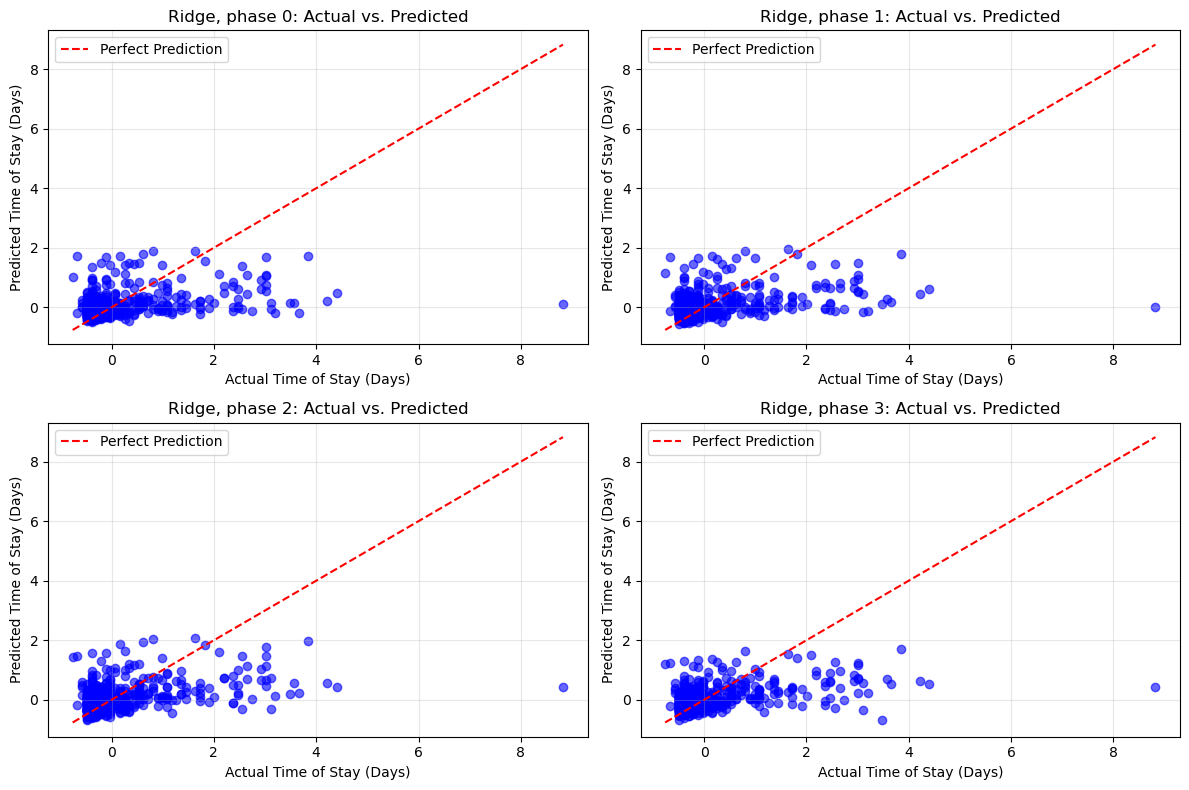

     Phase  Features       MAE       MSE      RMSE        R²
0  Phase 0        47  0.444438  0.582487  0.763208  0.127160
1  Phase 1        98  0.441297  0.573235  0.757123  0.141024
2  Phase 2       133  0.429694  0.542824  0.736766  0.186594
3  Phase 3       193  0.418116  0.530944  0.728659  0.204396


In [20]:
model = Ridge()

alpha_parameter = np.logspace(-5, 5, 20)  # L2 regularization strength

param_grid = {
    'alpha': alpha_parameter  # Only parameter for Ridge regression
}

#Define phases
preFeatures = preOpDataDF.columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['TimeOfStayInDays'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_std['TimeOfStayInDays'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_std['TimeOfStayInDays'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_std['TimeOfStayInDays'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_std['TimeOfStayInDays'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_std['TimeOfStayInDays'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Time of Stay (Days)')
    plt.ylabel('Predicted Time of Stay (Days)')
    plt.title(f'Ridge, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Operation length


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 100000.0}
Holdout Set Mean Absolute Error (MAE): 0.70
Holdout Set Mean Squared Error (MSE): 0.88
Holdout Set Root Mean Squared Error (RMSE): 0.94
Holdout Set R² Score: -0.0021

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 100000.0}
Holdout Set Mean Absolute Error (MAE): 0.70
Holdout Set Mean Squared Error (MSE): 0.88
Holdout Set Root Mean Squared Error (RMSE): 0.94
Holdout Set R² Score: -0.0024

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best parameters: {'alpha': 100000.0}
Holdout Set Mean Absolute Error (MAE): 0.70
Holdout Set Mean Squared Error (MSE): 0.88
Holdout Set Root Mean Squared Error (RMSE): 0.94
Holdout Set R² Score: -0.0034


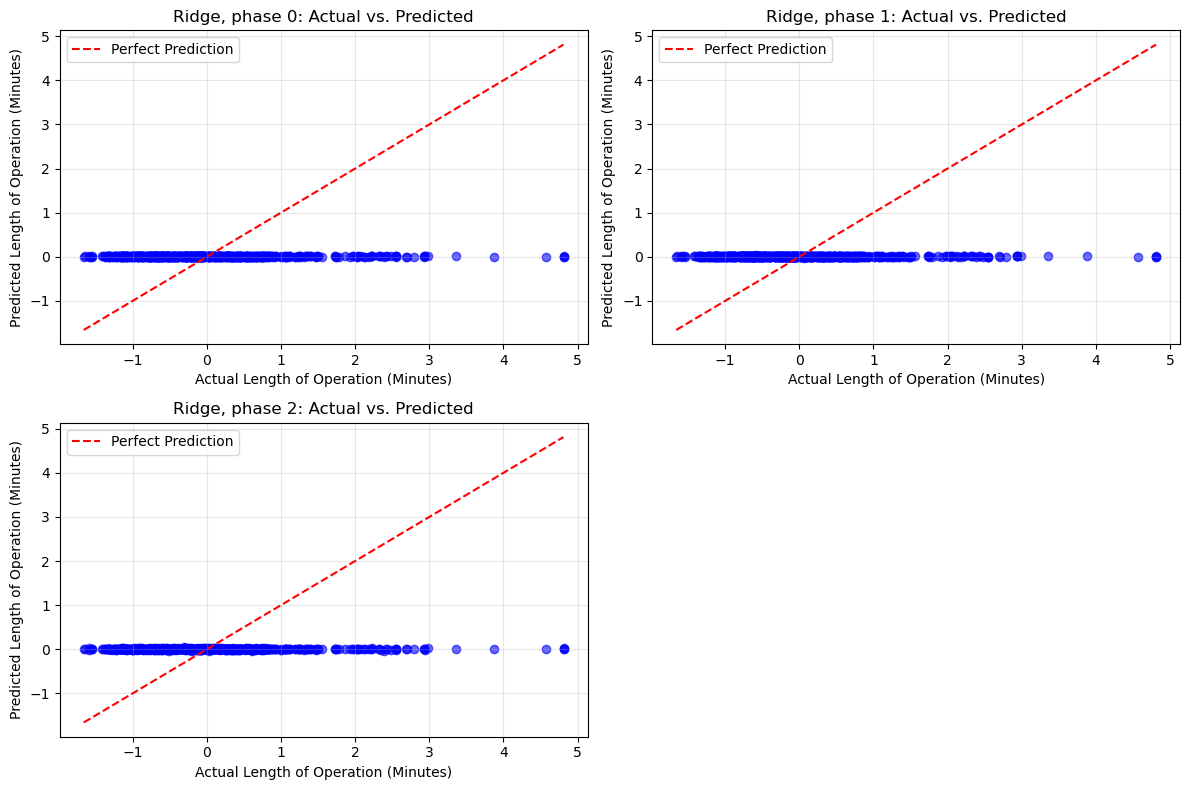

     Phase  Features       MAE       MSE      RMSE        R²
0  Phase 0        47  0.701906  0.882349  0.939334 -0.002133
1  Phase 1        98  0.702179  0.882613  0.939475 -0.002433
2  Phase 2       133  0.702500  0.883435  0.939912 -0.003367


In [21]:
#Define phases
preFeatures = preOpDataDF.columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()

phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['TimeOfOperationInMinutes'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_std['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_std['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_std['TimeOfOperationInMinutes'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_std['TimeOfOperationInMinutes'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_std['TimeOfOperationInMinutes'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Length of Operation (Minutes)')
    plt.ylabel('Predicted Length of Operation (Minutes)')
    plt.title(f'Ridge, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### Regression tree

Time of Stay


=== Phase 0: Using 38 features ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 5.02
Holdout Set Mean Squared Error (MSE): 137.40
Holdout Set Root Mean Squared Error (RMSE): 11.72
Holdout Set R² Score: -0.7492

=== Phase 1: Using 89 features ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 5.19
Holdout Set Mean Squared Error (MSE): 162.62
Holdout Set Root Mean Squared Error (RMSE): 12.75
Holdout Set R² Score: -1.0702

=== Phase 2: Using 124 features ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 5.12
Holdout Set Mean Squared Error (MSE): 145.72
Holdout Set Root Mean Squared Error (RMSE): 12.07
Holdout Set R² Score: -0.8550

=== Phase 3: Using 184 features 

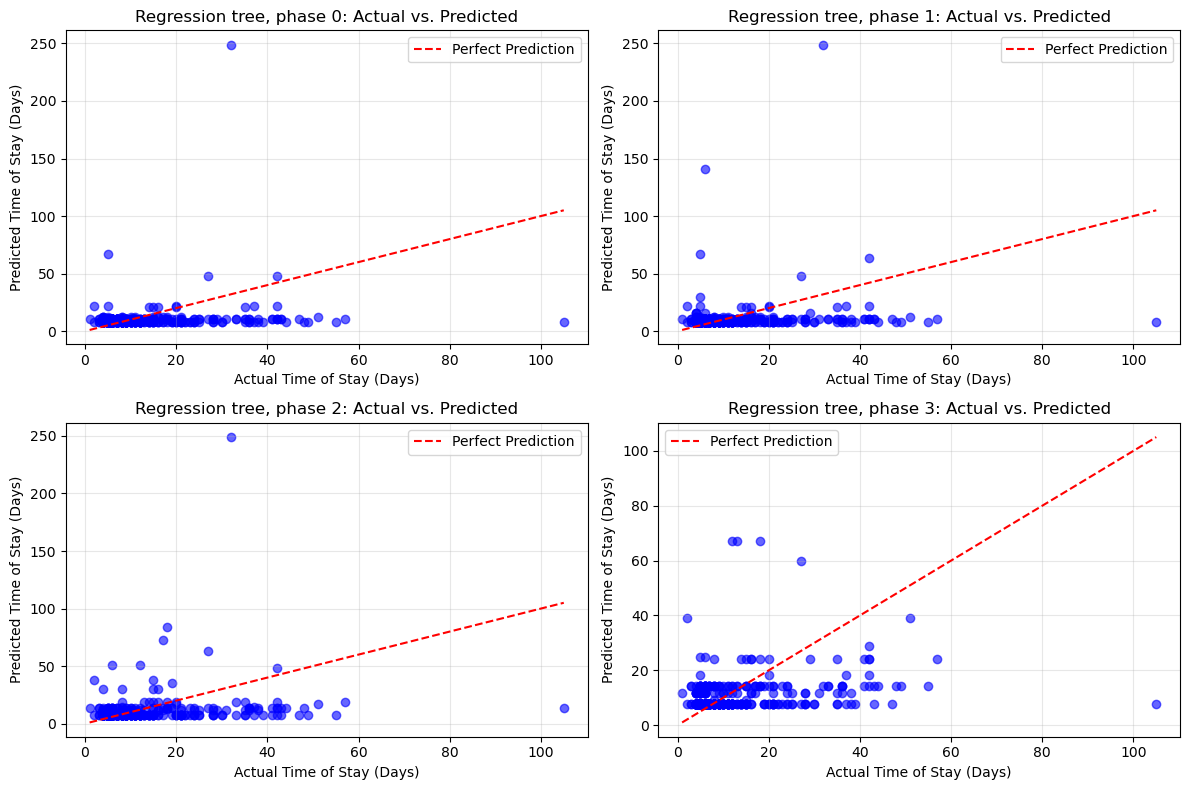

     Phase  Features       MAE         MSE       RMSE        R²
0  Phase 0        38  5.020405  137.404510  11.721967 -0.749177
1  Phase 1        89  5.186294  162.623565  12.752394 -1.070219
2  Phase 2       124  5.122612  145.715882  12.071283 -0.854982
3  Phase 3       184  4.675263   76.689563   8.757258  0.023732


In [22]:
model = DecisionTreeRegressor(random_state=0)
C_parameter = np.logspace(-5, 5, 20)
#C_parameter = [1.1e-24]
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],  #Use only one of these 3
    #'min_samples_split': [2, 5, 10, 20], #Use only one of these 3
    #'min_samples_leaf': [1, 5, 10, 20],  #Use only one of these 3
    'max_features': [None]  #None
}

#Define phases
preFeatures = preOpDataDF.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'
                            ]).columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['TimeOfStayInDays'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_norm['TimeOfStayInDays'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_norm['TimeOfStayInDays'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_norm['TimeOfStayInDays'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Time of Stay (Days)')
    plt.ylabel('Predicted Time of Stay (Days)')
    plt.title(f'Regression tree, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Operation length


=== Phase 0: Using 38 features ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 63.49
Holdout Set Mean Squared Error (MSE): 7511.72
Holdout Set Root Mean Squared Error (RMSE): 86.67
Holdout Set R² Score: -0.1335

=== Phase 1: Using 89 features ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 63.86
Holdout Set Mean Squared Error (MSE): 7450.88
Holdout Set Root Mean Squared Error (RMSE): 86.32
Holdout Set R² Score: -0.1243

=== Phase 2: Using 124 features ===
Fitting 10 folds for each of 5 candidates, totalling 50 fits
Best parameters: {'max_depth': 5, 'max_features': None}
Holdout Set Mean Absolute Error (MAE): 63.57
Holdout Set Mean Squared Error (MSE): 7505.35
Holdout Set Root Mean Squared Error (RMSE): 86.63
Holdout Set R² Score: -0.1326


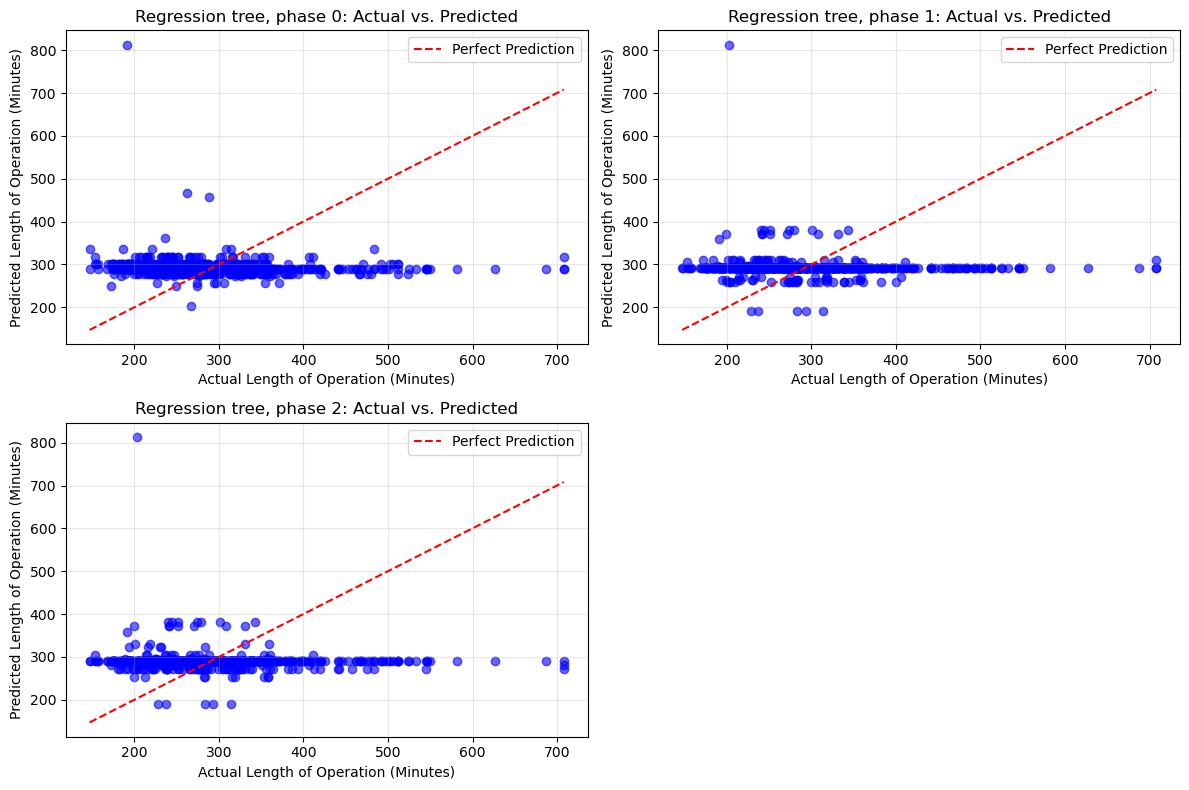

     Phase  Features        MAE          MSE       RMSE        R²
0  Phase 0        38  63.491567  7511.722709  86.670195 -0.133522
1  Phase 1        89  63.856033  7450.880419  86.318482 -0.124341
2  Phase 2       124  63.573812  7505.354180  86.633447 -0.132561


In [23]:
preFeatures = preOpDataDF.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'
                            ]).columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()

phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['TimeOfOperationInMinutes'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_norm['TimeOfOperationInMinutes'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Length of Operation (Minutes)')
    plt.ylabel('Predicted Length of Operation (Minutes)')
    plt.title(f'Regression tree, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### Multi-Layer Perceptron

Time of Stay


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 6.1584821106602545, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Holdout Set Mean Absolute Error (MAE): 0.41
Holdout Set Mean Squared Error (MSE): 0.60
Holdout Set Root Mean Squared Error (RMSE): 0.77
Holdout Set R² Score: 0.1068

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 20.6913808111479, 'hidden_layer_sizes': (10,), 'learning_rate_init': 0.001, 'solver': 'adam'}
Holdout Set Mean Absolute Error (MAE): 0.43
Holdout Set Mean Squared Error (MSE): 0.56
Holdout Set Root Mean Squared Error (RMSE): 0.75
Holdout Set R² Score: 0.1542

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 20.6913808111479, 'hidden_layer

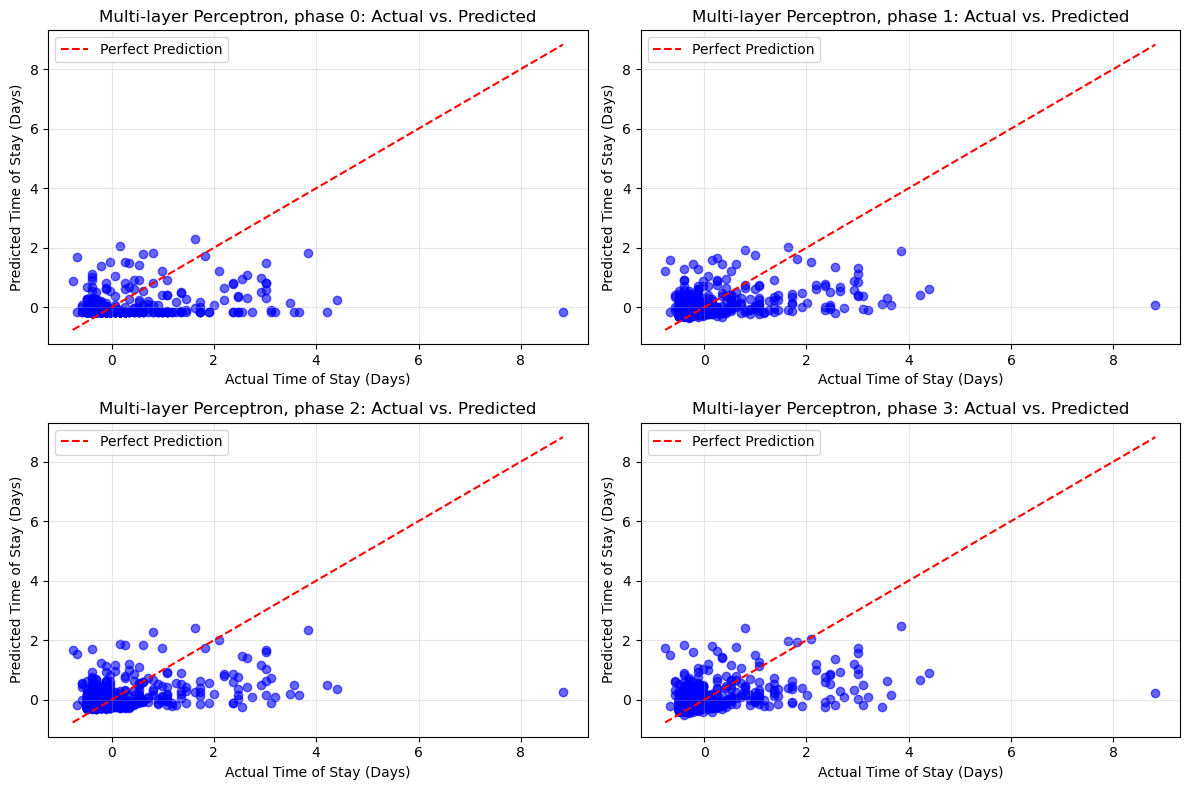

     Phase  Features       MAE       MSE      RMSE        R²
0  Phase 0        47  0.412942  0.596057  0.772047  0.106825
1  Phase 1        98  0.432022  0.564414  0.751275  0.154241
2  Phase 2       133  0.418202  0.541684  0.735992  0.188302
3  Phase 3       193  0.412501  0.539233  0.734325  0.191974


In [24]:
model = MLPRegressor(max_iter=200, random_state=0) #Increase max_iter

param_grid = {
    'hidden_layer_sizes': [(2,), (5,), (10,)], #potentially not 15 20
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': C_parameter, #Do the same as regression C_parameter
    'learning_rate_init': [0.001, 0.01, 0.1] 
}

#Define phases
preFeatures = preOpDataDF.columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['TimeOfStayInDays'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_std['TimeOfStayInDays'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_std['TimeOfStayInDays'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_std['TimeOfStayInDays'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_std['TimeOfStayInDays'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_std['TimeOfStayInDays'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Time of Stay (Days)')
    plt.ylabel('Predicted Time of Stay (Days)')
    plt.title(f'Multi-layer Perceptron, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Operation length


=== Phase 0: Using 47 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 233.57214690901213, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Holdout Set Mean Absolute Error (MAE): 0.70
Holdout Set Mean Squared Error (MSE): 0.88
Holdout Set Root Mean Squared Error (RMSE): 0.94
Holdout Set R² Score: -0.0017

=== Phase 1: Using 98 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'relu', 'alpha': 20.6913808111479, 'hidden_layer_sizes': (5,), 'learning_rate_init': 0.1, 'solver': 'adam'}
Holdout Set Mean Absolute Error (MAE): 0.70
Holdout Set Mean Squared Error (MSE): 0.88
Holdout Set Root Mean Squared Error (RMSE): 0.94
Holdout Set R² Score: -0.0000

=== Phase 2: Using 133 features ===
Fitting 10 folds for each of 360 candidates, totalling 3600 fits
Best parameters: {'activation': 'tanh', 'alpha': 100000.0, 'hidden_layer_sizes': (

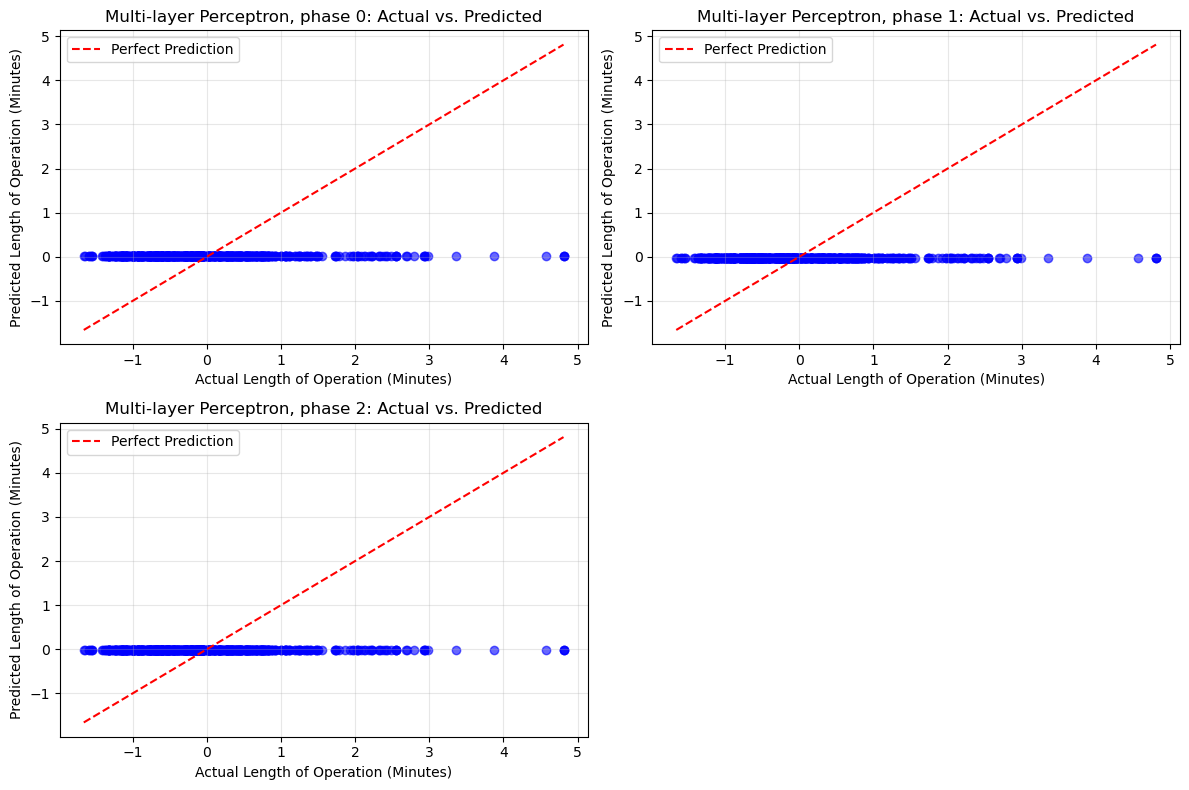

     Phase  Features       MAE       MSE      RMSE        R²
0  Phase 0        47  0.701837  0.881931  0.939112 -0.001658
1  Phase 1        98  0.695891  0.880509  0.938354 -0.000043
2  Phase 2       133  0.697688  0.880728  0.938471 -0.000292


In [25]:
#Define phases
preFeatures = preOpDataDF.columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()

phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_std[phase_features]
    X_test_phase = X_test_std[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_std['TimeOfOperationInMinutes'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_std['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_std['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_std['TimeOfOperationInMinutes'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_std['TimeOfOperationInMinutes'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_std['TimeOfOperationInMinutes'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Length of Operation (Minutes)')
    plt.ylabel('Predicted Length of Operation (Minutes)')
    plt.title(f'Multi-layer Perceptron, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

### XGBoost

Time of Stay


=== Phase 0: Using 38 features ===
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Error (MAE): 4.75
Holdout Set Mean Squared Error (MSE): 73.77
Holdout Set Root Mean Squared Error (RMSE): 8.59
Holdout Set R² Score: 0.0609

=== Phase 1: Using 89 features ===
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Error (MAE): 4.65
Holdout Set Mean Squared Error (MSE): 69.99
Holdout Set Root Mean Squared Error (RMSE): 8.37
Holdout Set R² Score: 0.1090

=== Phase 2: Using 124 features ===
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Error (MAE)

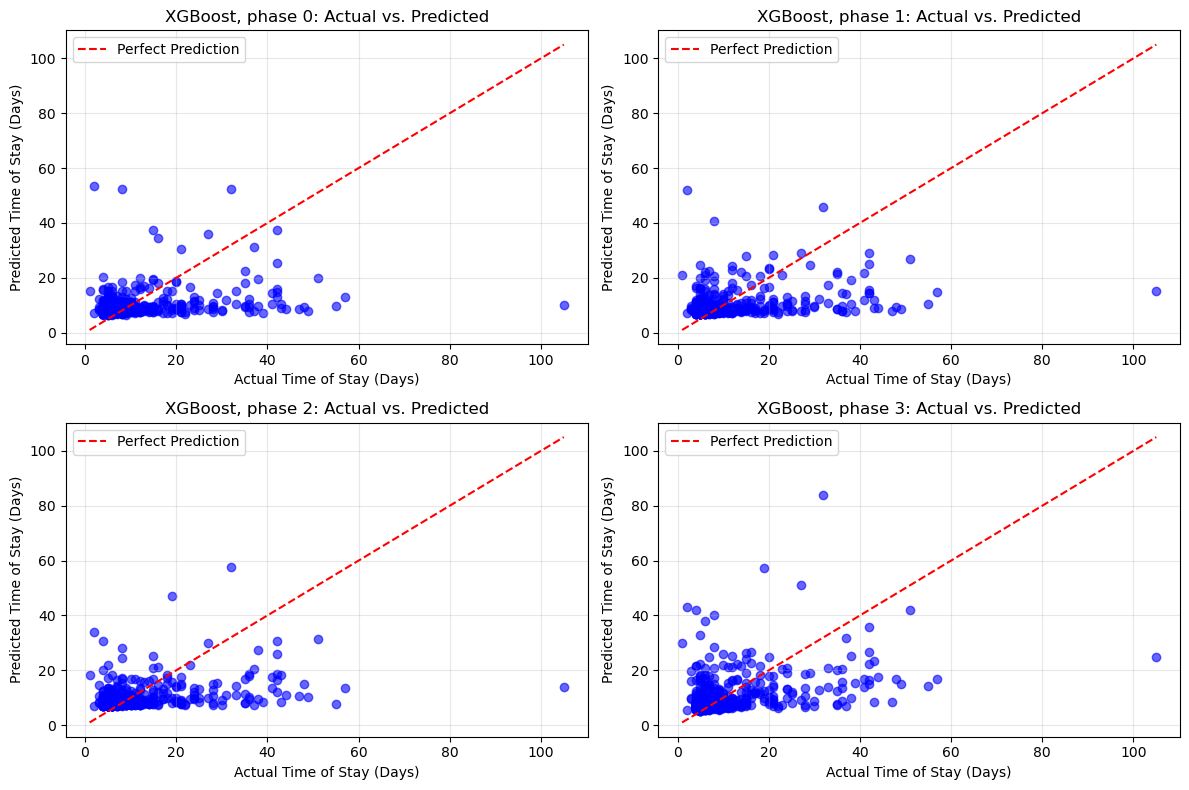

     Phase  Features       MAE        MSE      RMSE        R²
0  Phase 0        38  4.748515  73.766591  8.588748  0.060942
1  Phase 1        89  4.653512  69.992173  8.366133  0.108991
2  Phase 2       124  4.532477  65.760004  8.109254  0.162867
3  Phase 3       184  4.557406  71.205494  8.438335  0.093545


In [26]:
model = XGBRegressor(objective='reg:squarederror', eval_metric='rmse')

param_grid = {
    'max_depth': [5, 6, 7],           # Tree depth
    'learning_rate': [0.01, 0.1],     # Step size shrinkage
    'n_estimators': [50, 100, 200],   # Number of boosting rounds
    'reg_alpha': [1],                 # L1 regularization term
    'reg_lambda': [1]                 # L2 regularization term
}

#Define phases
preFeatures = preOpDataDF.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'
                            ]).columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()
phase3Features = phase3DF.columns[1:].tolist() 
phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
    preFeatures + phase1Features + phase2Features + phase3Features
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['TimeOfStayInDays'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_norm['TimeOfStayInDays'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_norm['TimeOfStayInDays'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_norm['TimeOfStayInDays'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_norm['TimeOfStayInDays'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Time of Stay (Days)')
    plt.ylabel('Predicted Time of Stay (Days)')
    plt.title(f'XGBoost, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)

Operation length


=== Phase 0: Using 38 features ===
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Error (MAE): 61.22
Holdout Set Mean Squared Error (MSE): 6713.91
Holdout Set Root Mean Squared Error (RMSE): 81.94
Holdout Set R² Score: -0.0131

=== Phase 1: Using 89 features ===
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Error (MAE): 61.26
Holdout Set Mean Squared Error (MSE): 6707.74
Holdout Set Root Mean Squared Error (RMSE): 81.90
Holdout Set R² Score: -0.0122

=== Phase 2: Using 124 features ===
Fitting 10 folds for each of 18 candidates, totalling 180 fits
Best parameters: {'learning_rate': 0.01, 'max_depth': 5, 'n_estimators': 50, 'reg_alpha': 1, 'reg_lambda': 1}
Holdout Set Mean Absolute Erro

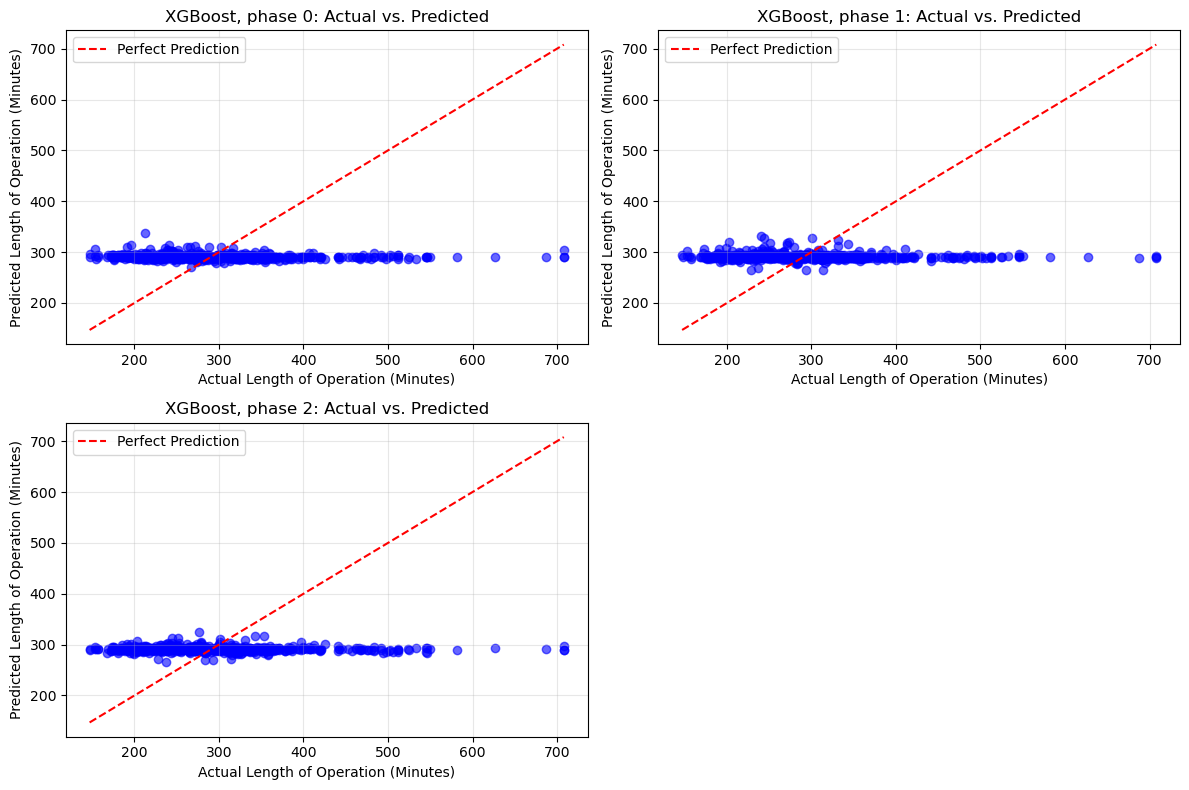

     Phase  Features        MAE          MSE       RMSE        R²
0  Phase 0        38  61.218903  6713.910251  81.938454 -0.013132
1  Phase 1        89  61.258277  6707.737678  81.900779 -0.012200
2  Phase 2       124  61.136271  6680.006562  81.731307 -0.008015


In [27]:
preFeatures = preOpDataDF.drop(columns = ['SmokingStatus_No', 'SmokingStatus_Not anymore', 'SmokingStatus_Not asked', 'SmokingStatus_Yes', 
                            'AlcoholPerWeek_0','AlcoholPerWeek_0.5-10', 'AlcoholPerWeek_11-20', 'AlcoholPerWeek_21-30', 'AlcoholPerWeek_31+'
                            ]).columns[1:].tolist()
phase1Features = phase1DF.columns[1:].tolist()
phase2Features = phase2DF.columns[1:].tolist()

phases = [
    preFeatures,
    preFeatures + phase1Features,
    preFeatures + phase1Features + phase2Features,
]

# Metrics storage
metrics = []  # To store evaluation metrics for each phase
phase_predictions = []  # To store actual vs predicted data for plots

# Iterate through the phases
for i, phase_features in enumerate(phases):  # 'phases' from previous example
    print(f"\n=== Phase {i}: Using {len(phase_features)} features ===")
    
    # Select features for the current phase
    X_train_phase = X_train_norm[phase_features]
    X_test_phase = X_test_norm[phase_features]
    
    # Initialize GridSearchCV
    grid_search_phase = GridSearchCV(model, param_grid, cv=10, verbose=4, scoring='neg_mean_absolute_error', return_train_score=True, n_jobs=-1)
    
    # Fit the GridSearchCV model
    grid_search_phase.fit(X_train_phase, y_train_norm['TimeOfOperationInMinutes'])
    
    # Extract the best model and parameters
    best_model_phase = grid_search_phase.best_estimator_
    best_params_phase = grid_search_phase.best_params_
    
    # Evaluate the model on the holdout set
    y_pred_phase = best_model_phase.predict(X_test_phase)
    
    # Calculate metrics
    holdout_mae = mean_absolute_error(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_mse = mean_squared_error(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase)
    holdout_rmse = mean_squared_error(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase, squared=False)
    holdout_r2 = r2_score(y_test_norm['TimeOfOperationInMinutes'], y_pred_phase)
    
    # Store metrics for this phase
    metrics.append({
        'Phase': f'Phase {i}',
        'Features': len(phase_features),
        'MAE': holdout_mae,
        'MSE': holdout_mse,
        'RMSE': holdout_rmse,
        'R²': holdout_r2
    })
    
    # Store actual vs predicted values for plotting
    phase_predictions.append((y_test_norm['TimeOfOperationInMinutes'], y_pred_phase))
    
    # Print the summary for this phase
    print(f"Best parameters: {best_params_phase}")
    print(f"Holdout Set Mean Absolute Error (MAE): {holdout_mae:.2f}")
    print(f"Holdout Set Mean Squared Error (MSE): {holdout_mse:.2f}")
    print(f"Holdout Set Root Mean Squared Error (RMSE): {holdout_rmse:.2f}")
    print(f"Holdout Set R² Score: {holdout_r2:.4f}")

# Plot actual vs. predicted values for all phases
plt.figure(figsize=(12, 8))
for i, (actual, predicted) in enumerate(phase_predictions):
    plt.subplot(2, 2, i + 1)
    plt.scatter(actual, predicted, alpha=0.6, color='blue')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual Length of Operation (Minutes)')
    plt.ylabel('Predicted Length of Operation (Minutes)')
    plt.title(f'XGBoost, phase {i}: Actual vs. Predicted')
    plt.legend()
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Display summary metrics for all phases
metrics_df = pd.DataFrame(metrics)
print(metrics_df)